To-do:
- run reliability on connectomes as is
- consider revisiting: mask for only voxels that all sessions have signal from? or voxels that each subject has at least one session with signal from?
- Figure out task decoding and write task_decoding.py


To think about:
- Searchlights instead of parcels as connectivity targets, or as SRM boundaries
- Distance as SRM penalty instead of parcelwise
- DiFuMo atlas instead of Schaefer?
- Reliability.py: permutation tests?
- What kind of task decoding

In [184]:
import glob
import numpy as np
import nibabel as nib
from nilearn.plotting import view_img, plot_glass_brain

['missing-0_mask-double', 'missing-0_mask-gm', 'missing-11_mask-double', 'missing-11_mask-gm', 'missing-6_mask-double', 'missing-6_mask-gm']
[144.0, 644.0, 0.0, 0.0, 0.0, 0.0]


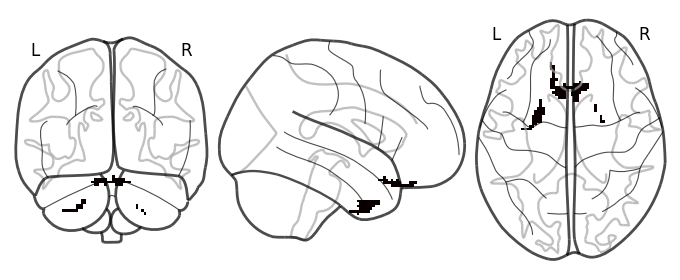

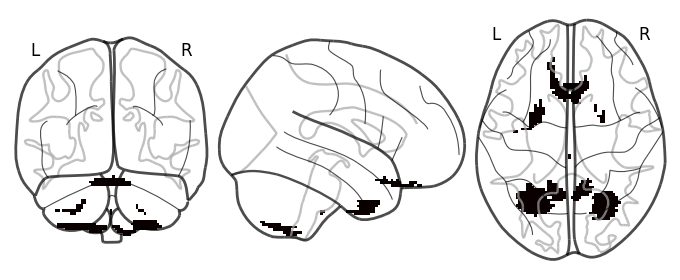

In [191]:
affine = nib.load('data/rest/sub-s03_ses-01_task-rest_run-1_space-MNI_desc-optcomDenoised_bold.nii.gz').affine
fnames = glob.glob('outputs/srm/missing*')
print([f[12:-4] for f in fnames])
files = [np.load(f).astype(float) for f in fnames]
print([np.sum(f) for f in files])
plot_glass_brain(nib.Nifti1Image(files[0], affine))
plot_glass_brain(nib.Nifti1Image(files[1], affine))